In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import ParameterGrid

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Import mlflow
from mlflow import log_metric, log_param, log_figure, set_experiment, set_tags, start_run, end_run, set_tracking_uri
from mlflow.sklearn import log_model

## Funções para o salvamento do módelo no MLflow

In [10]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)
    mdae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, msle, mdae, r2


def register_mlflow(exp_name, model, hyperparams, y_test, y_pred):
    set_experiment(exp_name)
    with start_run(run_name=exp_name):
        mae, mse, msle, mdae, r2 = metrics(y_test, y_pred)

        for p in hyperparams:
            log_param(p, hyperparams[p])

        # metrics
        log_metric("mae", mae)
        log_metric("mse", mse)
        log_metric("msle", msle)
        log_metric("mdae", mdae)
        log_metric("r2", r2)

        # model
        log_model(model, "model")

## Carregando os dadasets

In [11]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()

X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'-' * 27)
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11591, 59)
y_train shape: (11591,)
---------------------------
X_test shape: (4968, 59)
y_test shape: (4968,)


## Criando e treinando o módelo de "produção"

Utilizando AdaboostRegressor que foi o módelo escolhido no gridsearch

In [12]:
prod_model = AdaBoostRegressor(base_estimator=RandomForestRegressor(), loss='linear')
prod_model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor())

## Avaliando o módelo

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


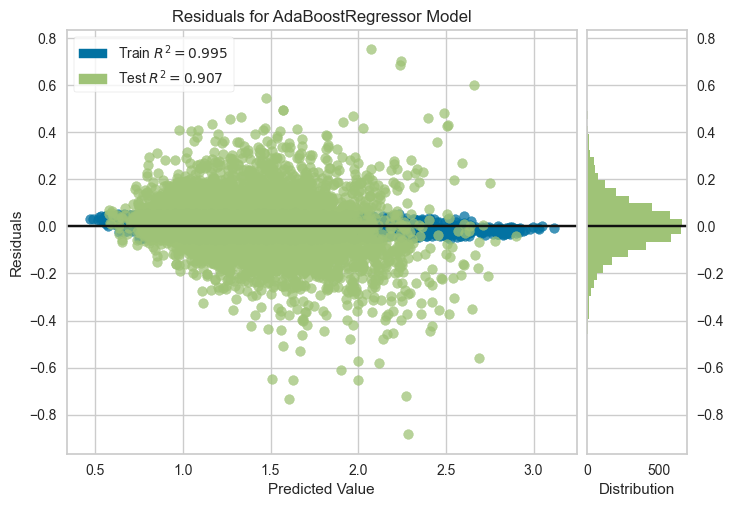

<AxesSubplot: title={'center': 'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [15]:
visualizer = ResidualsPlot(prod_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


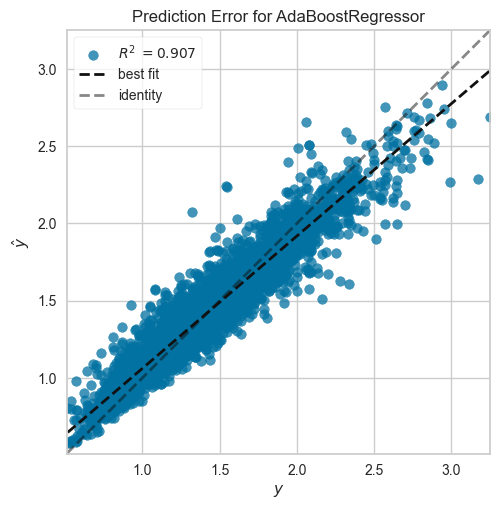

<AxesSubplot: title={'center': 'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [16]:
visualizer = PredictionError(prod_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

## Salvando no MLflow

In [17]:
y_pred = prod_model.predict(X_test)

register_mlflow(exp_name='Avocado AdaBoostRegressor', model=prod_model, hyperparams=prod_model.get_params(), 
                y_test=y_test, y_pred=y_pred)

2022/11/23 12:38:05 INFO mlflow.tracking.fluent: Experiment with name 'Avocado AdaBoostRegressor' does not exist. Creating a new experiment.
/home/enacom/.virtualenvs/py3cv4/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
